In [1]:
%matplotlib inline
import numpy
numpy.random.seed(0)

In [2]:
def get_dataset(n=250):
    """ Creates a simple 1D dataset.
    """

    numpy.random.seed(0)
    
    X = numpy.linspace(0, 3*numpy.pi, n)
    y = 0.5*numpy.sin(X) + numpy.random.normal(0, 0.1, n)
    
    return X, y

In [7]:
class LeastSquaresRegression():
    
    def __init__(self, lam=1.0, kernel="rbf", gamma=1.0, r=None, random_state=0):
        """ Instantiates the regression model.
        
        Parameters
        ----------
        lam : float, default 1.0
            The regularization parameter lambda
        kernel : string, default 'rbf'
            The kernel to be used
        gamma : float, default 1.0
            The kernel width gamma for the RBF kernel
        r : int or None, default None
            If None, then use all the training instances
            to represent the model. Otherwise, only 
            r random training instances are used (1 <= r <= n).
        random_state : int, default 0
            The random state (seed) to be used.
        """
        
        self.lam = lam
        self.kernel = kernel
        self.gamma = gamma
        self.r = r
        self.random_state = random_state

    def get_params(self, deep=True):
        """ Returns the parameters of the model
        """
        
        return {"lam": self.lam, 
                "kernel": self.kernel, 
                "gamma": self.gamma, 
                "r": self.r,
                "random_state": self.random_state}

    def set_params(self, **parameters):
        """ Sets the parameters of the model
        """        
        
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        return self
    
    def fit(self, X, y):
        """
        Fits the regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """   
        
        numpy.random.seed(self.random_state)
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray);
        # for y, we want to have a column vector
        X = numpy.array(X).reshape((X.shape[0], -1))
        y = numpy.array(y).reshape((len(y), 1))

        self._Xtrain = X
        self._ytrain = y
        
        if self.r is None:
        
            km = self._compute_kernel_matrix(self._Xtrain, self._Xtrain)
            shifted_km = km + len(self._ytrain) * self.lam * numpy.identity(len(self._Xtrain))

            # Ex 1.1: ADAPT THE CODE HERE
            #self._c = numpy.dot(numpy.linalg.inv(shifted_km), self._ytrain)  
            self._c = numpy.linalg.solve(shifted_km, self._ytrain)
            
        else:

            assert self.r >= 1
            assert self.r <= X.shape[0]
            
            rsub = numpy.random.choice(X.shape[0], self.r, replace=False)
            self._Xtrain_sub = self._Xtrain[rsub]
            self._ytrain_sub = self._ytrain[rsub]
            
            # Ex 1.3: YOUR CODE HERE
            # (make sure that you also use numpy.linalg.solve here)
            
            km = self._compute_kernel_matrix(self._Xtrain_sub, self._Xtrain_sub)
            shifted_km = km + len(self._ytrain_sub) * self.lam * numpy.identity(len(self._Xtrain_sub))
            self._c = numpy.linalg.solve(shifted_km, self._ytrain_sub)
            
        return self
    
    def fit_shortcut(self, X, y, lam=1.0):
        """
        Fits the regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """   
        
        numpy.random.seed(self.random_state)
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray);
        # for y, we want to have a column vector
        X = numpy.array(X).reshape((X.shape[0], -1))
        y = numpy.array(y).reshape((len(y), 1))

        self._Xtrain = X
        self._ytrain = y
        self.lam = lam
        
        if self.r is None:

            # Ex 1.4: YOUR CODE HERE
            km = self._compute_kernel_matrix(self._Xtrain, self._Xtrain)
            evals, evecs = numpy.linalg.eigh(km)
            d = numpy.diag(evals)
            B1 = numpy.dot(numpy.transpose(evecs), self._ytrain)
            B2 = numpy.linalg.inv(d + len(self._ytrain) * self.lam * numpy.identity(len(self._Xtrain)))
            B3 = numpy.dot(B2, B1)
            self._c = numpy.dot(evecs, B3)
                        
        else:

            assert self.r >= 1
            assert self.r <= X.shape[0]
            
            # Not needed to be implemented for this homework!
            raise Exception("Not part of this homework")

        return self    
        
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of shape [n_samples, 1]
        """           
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray)
        X = numpy.array(X).reshape((X.shape[0], -1))

        if self.r is None:
            
            km = self._compute_kernel_matrix(X, self._Xtrain)
            preds = numpy.dot(km, self._c)
            
        else:
            
            # Ex 1.3: YOUR CODE HERE
            km = self._compute_kernel_matrix(X, self._Xtrain_sub)
            preds = numpy.dot(km, self._c)
    
        return preds
            
    def _compute_kernel_matrix(self, X1, X2):
        """ Computes the kernel matrix
        """
        
        if self.kernel == "rbf":
            
            km = numpy.empty((X1.shape[0], X2.shape[0]), dtype=numpy.float64)
            
            for i in range(X1.shape[0]):
                for j in range(X2.shape[0]):
                    diff = X1[i] - X2[j]
                    tmp = numpy.dot(diff, diff)
                    km[i,j] = numpy.exp(- self.gamma * tmp)

            return km
        
        elif self.kernel == "fast_rbf":
            
            # Ex 1.2: YOUR CODE HERE
            km = numpy.empty((X1.shape[0], X2.shape[0]), dtype=numpy.float64)
            prod = numpy.dot(X1, numpy.transpose(X2))
            p = -self.gamma * prod
            e = numpy.full((prod.shape), numpy.exp(1))
            km = numpy.power(e, p)
            km = numpy.array(km)
            
            return km
            
                    
        else:
            
            raise Exception("Unknown kernel: {}".format(self.kernel))


For demonstration purposes: Let's generate some toy data to illustrate the effect of the different parameters.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X, y = get_dataset()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

lams = [10, 0.01, 0.0001]
gammas = [0.1, 2, 1000]

f, axes = plt.subplots(1, 3, sharey=True, figsize=(15,5))

for (lam, gamma, i) in zip(lams, gammas, range(len(lams))):

    model = LeastSquaresRegression(kernel="rbf", lam=lam, gamma=gamma)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # plot test points and predictions
    axes[i].scatter(X_test, y_test, s=100, c="b", edgecolor="k", linewidths=1, label="True")
    axes[i].scatter(X_test, preds, s=100, c="r", edgecolor="k", linewidths=1, label="Predictions")

    # plot model
    x = numpy.linspace(X.min(), X.max(), 500)
    axes[i].plot(x, model.predict(x), "-k", alpha=0.8, linewidth=3.0, label="Model")

    axes[i].set_xlabel("X")
    axes[i].set_ylabel("y")
    axes[i].legend(loc=0)
    
plt.show()

In [ ]:
# Ex 1.1: Avoid the computation of the inverse of the matrix;
# instead, make use of numpy.linalg.solve. Afterwards, measure 
# the runtimes needed by the fit function for datasets of 
# increasing size n (see below)

import time

n_range = [100*i for i in range(1,11)]

lam = 0.01
gamma = 2.0

fig, ax = plt.subplots()

results_exact = []

for n in n_range:
    
    print("Processing dataset of size {} ...".format(n))

    X_train, y_train = get_dataset(n=n)

    start = time.time()
    model = LeastSquaresRegression(kernel="rbf", lam=lam, gamma=gamma)
    model.fit(X_train, y_train)      
    end = time.time()
    
    results_exact.append(end-start)        
        
ax.plot(range(1,11), results_exact, label="runtime (exact)")
ax.legend()
plt.show()

In [ ]:
# Ex 1.2: Accelerate the computation of the kernel matrix 
# by make use of more efficient Numpy array operations. That
# is, try to avoid the two neested Python loops and the 
# individual kernel value computations. Extend the code by
# providing a 'new' kernel 'fast_rbf', see above. Conduct a 
# similar runtime experiment as before (new plot). Which 
# speed-up do you get for n=1000 training instances?

import time

n_range = [100*i for i in range(1,11)]

lam = 0.01
gamma = 1.0

fig, ax = plt.subplots()

results_exact = []
results_exact_fast = []

for n in n_range:
    
    print("Processing dataset of size {} ...".format(n))

    X_train, y_train = get_dataset(n=n)

    start = time.time()
    model = LeastSquaresRegression(kernel="rbf", lam=lam, gamma=gamma)
    model.fit(X_train, y_train)      
    end = time.time()
    results_exact.append(end-start)        
    
    start = time.time()
    model = LeastSquaresRegression(kernel="fast_rbf", lam=lam, gamma=gamma)
    model.fit(X_train, y_train)      
    end = time.time()
    results_exact_fast.append(end-start)            
        
ax.plot(range(1,11), results_exact, label="runtime (exact)")
ax.plot(range(1,11), results_exact_fast, label="runtime (exact, fast)")
ax.legend()
plt.show()
print("Speed-Up: {}".format(results_exact[-1] / results_exact_fast[-1]))

In [ ]:
# Ex 1.3: 
# - Extend the class LeastSquaresRegression such 
#   that it implements the approximation scheme discussed
#   during the lecture that resorts models being based on
#   only r training instances.
# - conduct a similar runtime experiment as above and
#   compare the runtimes of the exact approach with the 
#   ones of the approximation scheme (see below)

# NOTE: Use n_range = [100*i for i in range(1,11)] in case 
# you have to make use of the slow kernel='rbf'

n_range = [500*i for i in range(1,11)]

lam = 0.01
gamma = 1.0
r = 50

import time

fig, ax = plt.subplots()

results_exact_fast = []
results_approx = []

for n in n_range:
    
    print("Processing dataset of size {} ...".format(n))

    X_train, y_train = get_dataset(n=n)
    
    start = time.time()
    model = LeastSquaresRegression(kernel="fast_rbf", lam=lam, gamma=gamma)
    model.fit(X_train, y_train)      
    end = time.time()
    results_exact_fast.append(end-start)            
    
    start = time.time()
    model = LeastSquaresRegression(kernel="fast_rbf", lam=lam, gamma=gamma, r=50)
    model.fit(X_train, y_train)      
    end = time.time()
    results_approx.append(end-start)
        
ax.plot(range(1,11), results_exact_fast, label="runtime (exact, fast)")
ax.plot(range(1,11), results_approx, label="runtime (approx, fast)")
ax.legend()
plt.show()
print("Speed-Up: {}".format(results_exact_fast[-1] / results_approx[-1]))

Elapsed time: 1.2249376773834229
Elapsed time: 1.199836254119873
Elapsed time: 1.014040231704712
Elapsed time: 1.2092278003692627
Elapsed time: 1.4433608055114746
Elapsed time: 1.7885363101959229
Elapsed time: 1.4236512184143066
Elapsed time: 1.4199721813201904
Elapsed time: 1.4394309520721436
Elapsed time: 1.463561773300171
Elapsed time: 1.449247121810913
Elapsed time: 1.403289794921875
Elapsed time: 1.4171481132507324
Elapsed time: 1.3885722160339355
Elapsed time: 1.4725542068481445
Elapsed time: 1.6538848876953125
Elapsed time: 1.56685209274292
Elapsed time: 1.6682331562042236
Elapsed time: 1.6275303363800049
Elapsed time: 1.4220483303070068
Elapsed time: 1.4102106094360352
Elapsed time: 1.4012248516082764
Elapsed time: 1.4622769355773926
Elapsed time: 1.419452428817749
Elapsed time: 1.4004435539245605
Elapsed time: 1.4054358005523682
Elapsed time: 1.629991054534912
Elapsed time: 2.3323047161102295
Elapsed time: 3.699841260910034
Elapsed time: 2.8896069526672363
Elapsed time: 2.4164

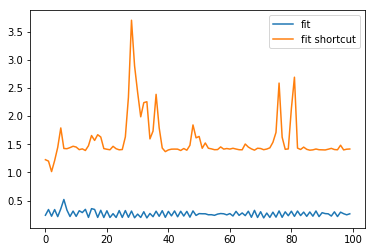

In [8]:
# Ex 1.4: Implement the efficient search for lambda 
# as disussed during the lecture. 

import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1500, n_features=50, random_state=0, noise=4.0, bias=0.0)

gamma = 1.0 / 50.0
lams = numpy.arange(0, 10, 0.1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.333333, random_state=1)

model = LeastSquaresRegression(kernel="fast_rbf", gamma=gamma, r=None)

sols_shortcut = []
elapsed_shortcut = []
for lam in lams:
    start = time.time()
    model.fit_shortcut(X_train, y_train, lam=lam)
    sols_shortcut.append(model._c)
    end = time.time()
    elapsed_shortcut.append(end-start)
    print("Elapsed time: {}".format(end-start))

elapsed_normal = []
sols_normal = []
for lam in lams:    
    model = LeastSquaresRegression(kernel="fast_rbf", lam=lam, gamma=gamma, r=None)
    start = time.time()
    model.fit(X_train, y_train)
    sols_normal.append(model._c)
    end = time.time()
    elapsed_normal.append(end-start)
    print("Elapsed time: {}".format(end-start))


# sanity check: Are the computed solutions the same?
for i in range(len(sols_normal)):
    assert numpy.allclose(sols_normal[i], sols_shortcut[i])

# runtime plot
fig, ax = plt.subplots()
ax.plot(range(len(lams)), elapsed_normal, label="fit")
ax.plot(range(len(lams)), elapsed_shortcut, label="fit shortcut")
ax.legend()
plt.show()
